# HW3+4: Sketching and Music
In this notebook assignment we will experiment with generating sketches and musing using the [Google Magenta](https://magenta.tensorflow.org/) tools.

Magenta provides many pretrained models as well as tutorials on how to use them on their Github: https://github.com/tensorflow/magenta/tree/master/magenta/models

We will follow a couple of examples from there, focusing on Sketch-RNN and a few of the music generators using more RNNs.

In [3]:
# in case these are not already installed...
!pip install svgwrite magenta

The above cell may fail. We've seen problems on linux with ALSA (sound drivers).

A possible solution for linux (Ubuntu/Debian) is to open a terminal and install the following

```
sudo apt-get install libasound2-dev
sudo apt-get install libsndfile1-dev
pip3 install sndfile
```

You can then `pip3 install magenta` again to see if it goes through. You may also want to restart your VM, just for good measure.

On MacOSX you should be able to simply use `pip install` and it mostly likely will work right away.

In [0]:
from IPython.display import SVG, display

In [0]:
import numpy as np
import time
import random
import pickle as cPickle
import codecs
import collections
import os
import math
import json
from six.moves import xrange

We need to hack NumPy a little to allow pickles:

In [0]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [0]:
import svgwrite

In [0]:
# clear up TensorFlow's warnings a bit
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [9]:
import tensorflow as tf

## Sketch RNN

sketch-rnn is a Sequence-to-Sequence Variational Autoencoder. The encoder RNN is a bi-directional RNN, and the decoder is an autoregressive RNN ("feeds output into itself").

It is not unlike other VAEs we've seen where the latent space is enforced to resemble a Gaussian distribution.

<img src="https://camo.githubusercontent.com/1d108741379d5a6fc1cfcaa071103aaecd376369/68747470733a2f2f63646e2e7261776769742e636f6d2f74656e736f72666c6f772f6d6167656e74612f6d61737465722f6d6167656e74612f6d6f64656c732f736b657463685f726e6e2f6173736574732f736b657463685f726e6e5f736368656d617469632e737667" />

Google's project Magenta comes with pre-trained SketchRNN models.

In [0]:
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [0]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
    tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)

In [0]:
tf.get_logger().setLevel('ERROR') # be quiet, Tensorflow!

In [0]:
models_root_dir = '/tmp/sketch_rnn/models'
download_pretrained_models(models_root_dir=models_root_dir)

In [0]:
def load_sketch_rnn_model(model_dir):
    model_params = sketch_rnn_model.get_default_hparams()
    with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        data = json.load(f)
    fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
    for fix in fix_list:
        data[fix] = (data[fix] == 1)
    model_params.parse_json(json.dumps(data))
    return model_params
    
def load_env_compatible(data_dir, model_dir):
    model_params = load_sketch_rnn_model(model_dir)
    return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
    model_params = load_sketch_rnn_model(model_dir)

    model_params.batch_size = 1  # only sample one at a time
    eval_model_params = sketch_rnn_model.copy_hparams(model_params)
    eval_model_params.use_input_dropout = 0
    eval_model_params.use_recurrent_dropout = 0
    eval_model_params.use_output_dropout = 0
    eval_model_params.is_training = 0
    sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
    sample_model_params.max_seq_len = 1  # sample one point at a time
    return [model_params, eval_model_params, sample_model_params]

We load a dataset of sketches:

In [30]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300


In [0]:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

This function will take in a sketch (in the special SketchRNN format) and encode it to a vector. It's essentially an embedding for sketches, an "encoder":

In [0]:
def encode(input_strokes, draw_input = False):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    if draw_input:
        draw_strokes(to_normal_strokes(np.array(strokes)))
    return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

Naturally, we also have a "decoder" that takes in an embdding and reconstructs a sketch:

In [0]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    if draw_mode:
        draw_strokes(strokes, factor)
    return strokes

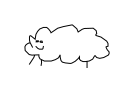

In [36]:
# get a sample drawing from the test set, and render it
stroke = test_set.random_sample()
draw_strokes(stroke)

In [0]:
z = encode(stroke)

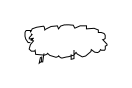

In [38]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

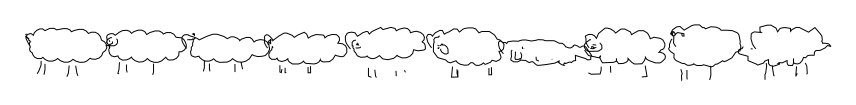

In [39]:
# generate with temperatures from 0.1 to 1.0
stroke_list = [[decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]] for i in range(10)]
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

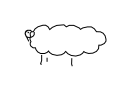

In [40]:
z0 = z
_ = decode(z0)

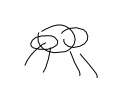

In [41]:
# take another sheep and encode it
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

In [0]:
# interpolate spherically between z0 and z1
z_list = [] 
N = 10
for t in np.linspace(0, 1, N):
    z_list.append(slerp(z0, z1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = [[decode(z_list[i], draw_mode=False), [0, i]] for i in range(N)]

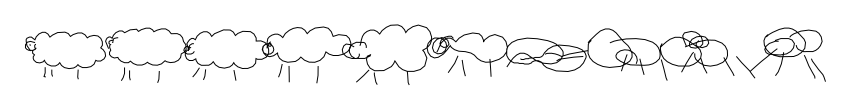

In [43]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's try **Flamingos**!

In [0]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

This is an unconditional model. Unconditional generation means the model will just generate a random vector image from scratch and not use any latent vectors as an input.

In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

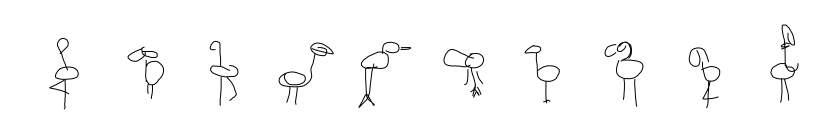

In [46]:
# randomly unconditionally generate 10 examples
reconstructions = [[decode(temperature=0.5, draw_mode=False), [0, i]] for i in range(10)]
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

This Owl model is conditional, so we can sample from a normal distribution and get random owls.

In [0]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

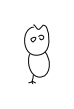

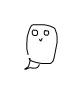

In [48]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

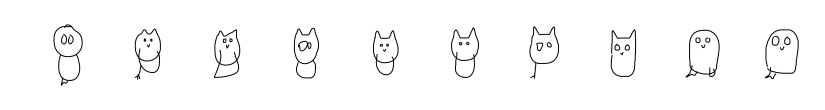

In [49]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
    z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
    reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

The SketchRNN folks also trained models on two categories at once, for example Pigs and Elephants.

In [0]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

Let's try to interpolate between pig and elephant. Finding a pig and an elephant may take a few tries.

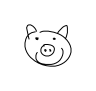

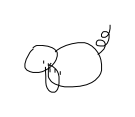

In [51]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

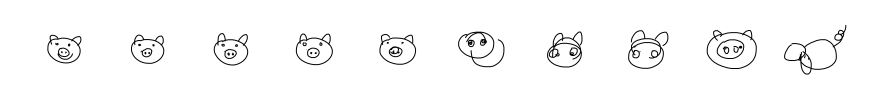

In [52]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
    z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = [[decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]] for i in range(N)]
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)
draw_strokes(stroke_grid, factor=0.3)

Pretrained Sketch-RNN models: https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn#pre-trained-models

Your turn...

Use the cat-bus pretrained model to:
- morph between a cat and a bus
- find a z vector of a cat with just a head and a cat with a whole body (this may take a few tries). subtract the "head" vector from the "whole body" vector, and add this "+body" vector to a different vector to see if you can "add a body".


In [0]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

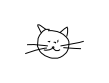

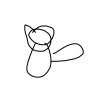

In [56]:
# todo cat to bus
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

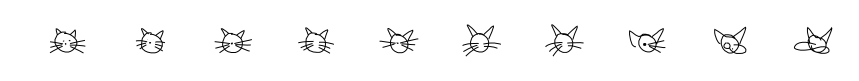

In [57]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
    z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = [[decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]] for i in range(N)]
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)
draw_strokes(stroke_grid, factor=0.3)

## Music RNNs

The Magenta project has many tools to generate music with RNNs:
- Drums RNN
- Polyphony RNN
- Improv RNN
- Melody RNN
- Performance RNN

and others.

Here we will use Performance RNN and Improv RNN, but you are encouraged to try the other ones as well.

In [0]:
import os
from magenta.models.performance_rnn import performance_sequence_generator
from magenta.protobuf import generator_pb2
from magenta.protobuf import music_pb2

import magenta.music as mm

### Performance RNN

This RNN generates a two-part piece: accompaniment and melody. It is very simple to use but since it's mostly unguided the result might sound unnatural -- jazzy though!

In [59]:
# Constants.
BUNDLE_DIR = '/tmp/bundles'
MODEL_NAME = 'performance_with_dynamics'
BUNDLE_NAME = MODEL_NAME + '.mag'

mm.notebook_utils.download_bundle(BUNDLE_NAME, BUNDLE_DIR)
bundle = mm.sequence_generator_bundle.read_bundle_file(os.path.join(BUNDLE_DIR, BUNDLE_NAME))
generator_map = performance_sequence_generator.get_generator_map()
generator = generator_map[MODEL_NAME](checkpoint=None, bundle=bundle)
generator.initialize()
generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = 1.0  # Higher is more random; 1.0 is default. 
generate_section = generator_options.generate_sections.add(start_time=0, end_time=30)
sequence = generator.generate(music_pb2.NoteSequence(), generator_options)

IOError: ignored

In [0]:
# Play and view this masterpiece.
mm.plot_sequence(sequence)
mm.play_sequence(sequence, mm.midi_synth.synthesize)

NameError: ignored

#### Improv RNN

This RNN generates a melody ("improvisation") over given base chord progression. It's quite nice!

In [0]:
from magenta.models.improv_rnn import improv_rnn_sequence_generator

In [0]:
BUNDLE_DIR = '/tmp/bundles'
MODEL_NAME = 'chord_pitches_improv'
BUNDLE_NAME = MODEL_NAME + '.mag'

mm.notebook_utils.download_bundle(BUNDLE_NAME, BUNDLE_DIR)
bundle = mm.sequence_generator_bundle.read_bundle_file(os.path.join(BUNDLE_DIR, BUNDLE_NAME))

IOError: ignored

In [0]:
generator_map = improv_rnn_sequence_generator.get_generator_map()
generator = generator_map[MODEL_NAME](checkpoint=None, bundle=bundle)
generator.initialize()
generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = 1.0  # Higher is more random; 1.0 is default. 


primer_melody = mm.Melody([60])
primer_sequence = primer_melody.to_sequence(qpm=mm.DEFAULT_QUARTERS_PER_MINUTE)
input_sequence = primer_sequence

# Create backing chord progression 
raw_chords = "C G Am F C G Am F".split()
repeated_chords = [chord for chord in raw_chords for _ in range(16)]
backing_chords = mm.ChordProgression(repeated_chords)

# Derive the total number of seconds to generate based on the QPM of the
# priming sequence and the length of the backing chord progression.
seconds_per_step = 60.0 / mm.DEFAULT_QUARTERS_PER_MINUTE / generator.steps_per_quarter
total_seconds = len(backing_chords) * seconds_per_step

last_end_time = max(n.end_time for n in primer_sequence.notes)
generate_section = generator_options.generate_sections.add(
    start_time=last_end_time + seconds_per_step,
    end_time=total_seconds)

# Add the backing chords to the input sequence.
chord_sequence = backing_chords.to_sequence(sequence_start_time=0.0, qpm=mm.DEFAULT_QUARTERS_PER_MINUTE)
for text_annotation in chord_sequence.text_annotations:
    if text_annotation.annotation_type == music_pb2.NoteSequence.TextAnnotation.CHORD_SYMBOL:
        chord = input_sequence.text_annotations.add()
        chord.CopyFrom(text_annotation)
input_sequence.total_time = len(backing_chords) * seconds_per_step

tf.logging.debug('input_sequence: %s', input_sequence)
tf.logging.debug('generator_options: %s', generator_options)

sequence = generator.generate(input_sequence, generator_options)
renderer = mm.BasicChordRenderer(velocity=50)
renderer.render(sequence)

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /var/folders/kj/r0vtt3hx2qn1mtb1wlx_n1880000gn/T/tmpnnwbep_g/model.ckpt
INFO:tensorflow:Beam search yields sequence with log-likelihood: -123.680397 


In [0]:
mm.plot_sequence(sequence)
mm.play_sequence(sequence, mm.midi_synth.synthesize)

Loading BokehJS ...

Try to generate pieces with your own or "standard" chord progressions (e.g. [these progressions](https://www.musical-u.com/learn/exploring-common-chord-progressions/)).

That's a wrap!